# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [0]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline


# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

'''    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )'''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [0]:
# default_seed = 1
# output_file = "output_sample"

# # Create a function to print a line to our output file
# def dump_to_output(key, value):
#     with open(output_file, "a") as f:
#         f.write(",".join([str(default_seed), key, str(value)]) + "\n")
        
# # Read the data and features from the pickle file saved in CS-Phase 2
# data, discrete_features, continuous_features, ret_cols = pickle.load( open( "output\clean_data.pickle", "rb" ) )

# ## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
# data["outcome"] = data['loan_status'].isin(['Charged Off', 'Default'])
# data["outcome"].head()

# # Create a feature for the length of a person's credit history at the time the loan is issued
# data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
# continuous_features.append('cr_hist')

# # Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
# np.random.seed(default_seed)
# ## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
# train_index = np.random.choice(data.index,int(len(data)*0.7))
# data['train'] = data.index.isin(train_index)
# data['train'].head()

# # Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
# X_continuous = data[continuous_features].values

# X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
# discrete_features_dummies = X_discrete.columns.tolist()
# X_discrete = X_discrete.values

# X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

# y = data.outcome.values

# train = data.train.values

In [0]:
default_seed = 1
output_file = "output_sample"

In [0]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [0]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "output/clean_data.pickle", "rb" ) )

In [0]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].isin(['Charged Off', 'Default'])
data["outcome"].head()

0    False
1     True
2    False
3    False
4    False
Name: outcome, dtype: bool

In [0]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [0]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
train_index = np.random.choice(data.index,int(len(data)*0.7))
data['train'] = data.index.isin(train_index)
data['train'].head()

0    False
1     True
2    False
3    False
4     True
Name: train, dtype: bool

In [0]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [0]:
X.shape, y.shape

((955533, 57), (955533,))

## Prepare functions to fit and evaluate models

In [0]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    global data
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    print(len(train), (date_range_train[0]), len(data_subset))
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [0]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    global data 
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
    print(len(data), len(data.grade), len(y_train_score), len(filter_train))
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred, 'auc': roc_auc_score(y_test, y_pred_probs)}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [0]:
## define your set of features to use in different models
your_features = list(data.columns)
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

955533 2010-02-01 955533


### Naive Bayes

  Model: NB
Fit time: 0.65 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80245
              precision    recall  f1-score   support

  No default     0.8024    1.0000    0.8904     16049
     Default     0.0000    0.0000    0.0000      3951

   micro avg     0.8024    0.8024    0.8024     20000
   macro avg     0.4012    0.5000    0.4452     20000
weighted avg     0.6439    0.8024    0.7145     20000



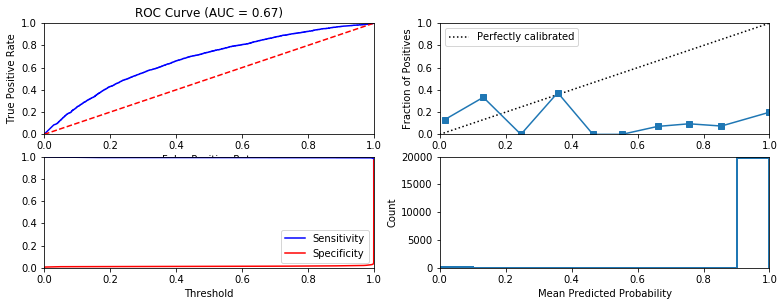


Similarity to LC grade ranking:  0.6490131185499757
Brier score: 0.7915505390992981
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.2467]


In [0]:
## Train and test a naive bayes classifier
gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name='NB')

### $l_1$ regularized logistic regression

  Model: LogitL1
Fit time: 24.71 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.5013337348682892
Accuracy:  0.80345
              precision    recall  f1-score   support

  No default     0.8071    0.9922    0.8901     16049
     Default     0.5370    0.0367    0.0687      3951

   micro avg     0.8034    0.8034    0.8034     20000
   macro avg     0.6721    0.5145    0.4794     20000
weighted avg     0.7537    0.8034    0.7279     20000



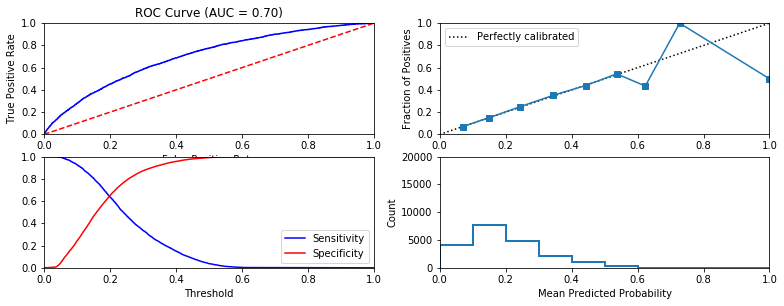


Similarity to LC grade ranking:  0.7517989955455001
Brier score: 0.1458044566925256
Were parameters on edge? : True
Score variations around CV search grid : 0.12036691155107349
[0.80213333 0.8024     0.8031    ]
0.6978877598642439


In [0]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':[0.01,0.1,1]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, model_name='LogitL1')
print(l1_logistic['auc'])

### $l_2$ regularized logistic regression

  Model: LogitL2
Fit time: 3.58 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.49210970203240506
Accuracy:  0.8033
              precision    recall  f1-score   support

  No default     0.8072    0.9917    0.8900     16049
     Default     0.5300    0.0380    0.0709      3951

   micro avg     0.8033    0.8033    0.8033     20000
   macro avg     0.6686    0.5148    0.4804     20000
weighted avg     0.7525    0.8033    0.7282     20000



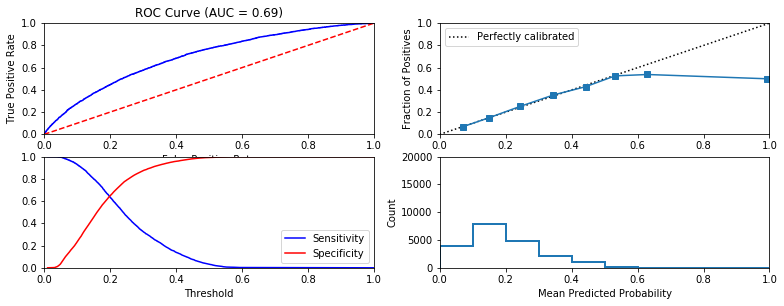


Similarity to LC grade ranking:  0.7703698857240963
Brier score: 0.1462877794713238
Were parameters on edge? : True
Score variations around CV search grid : 0.1285613569443865
[0.80273333 0.80283333 0.80376667]
0.6949873788036415


In [0]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[0.01,0.1,1]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, model_name='LogitL2')
print(l2_logistic['auc'])

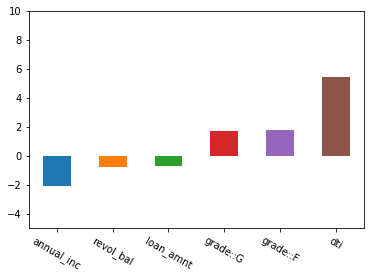

In [0]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

In [0]:
len(data.columns)

35

### Decision tree

  Model: Decision Tree
Fit time: 3.91 seconds
Optimal parameters:
{'max_depth': 5, 'max_features': 'log2'}

Accuracy-maximizing threshold was: 0.5185185185185185
Accuracy:  0.8014
              precision    recall  f1-score   support

  No default     0.8025    0.9982    0.8897     16049
     Default     0.2162    0.0020    0.0040      3951

   micro avg     0.8014    0.8014    0.8014     20000
   macro avg     0.5094    0.5001    0.4469     20000
weighted avg     0.6867    0.8014    0.7147     20000



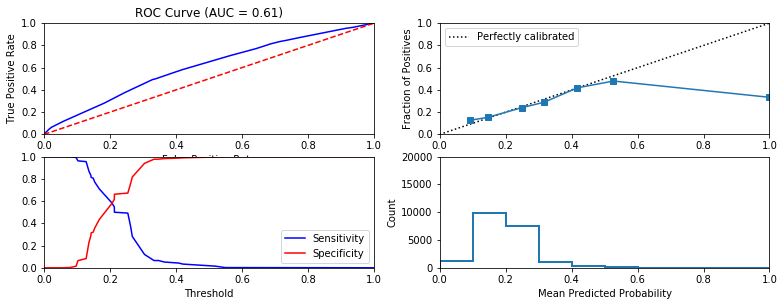

955533 955533 30000 955533

Similarity to LC grade ranking:  0.3141517688233673
Brier score: 0.15476089842826277
Were parameters on edge? : True
Score variations around CV search grid : 13.199170124481325
[0.80106667 0.80333333 0.7986     0.7871     0.78866667 0.7756
 0.70236667 0.6987     0.6973    ]


In [0]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[5,10,None],\
            'max_features':['sqrt','log2',None]
            }

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, model_name='Decision Tree')

### Random forest

  Model: RF
Fit time: 46.08 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.38158704897469287
Accuracy:  0.79665
              precision    recall  f1-score   support

  No default     0.8192    0.9579    0.8832     16049
     Default     0.4530    0.1415    0.2156      3951

   micro avg     0.7966    0.7966    0.7966     20000
   macro avg     0.6361    0.5497    0.5494     20000
weighted avg     0.7469    0.7966    0.7513     20000



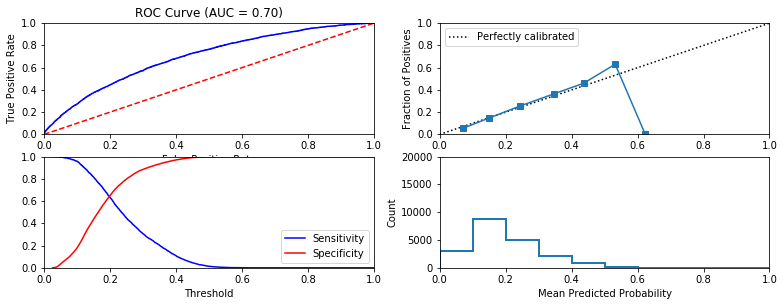

955533 955533 30000 955533

Similarity to LC grade ranking:  0.7230550918702877
Brier score: 0.14619835047494467
Were parameters on edge? : True
Score variations around CV search grid : 0.7845579078455894
[0.80276667 0.803      0.8027     0.7967     0.79823333 0.8002    ]


In [0]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {
                'max_depth':[10,20],\
                 'n_estimators':[20,50,100],\
                }


random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name='RF')

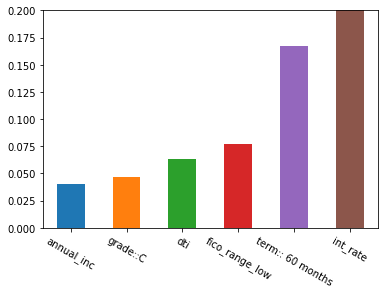

In [0]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP
Fit time: 25.64 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': 5}

Accuracy-maximizing threshold was: 0.4634070841735654
Accuracy:  0.8026
              precision    recall  f1-score   support

  No default     0.8061    0.9928    0.8898     16049
     Default     0.5064    0.0299    0.0564      3951

   micro avg     0.8026    0.8026    0.8026     20000
   macro avg     0.6563    0.5114    0.4731     20000
weighted avg     0.7469    0.8026    0.7251     20000



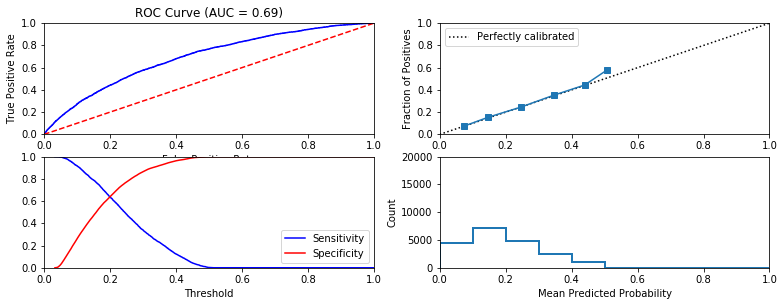

955533 955533 30000 955533

Similarity to LC grade ranking:  0.7453171686731006
Brier score: 0.14673368314671792
Were parameters on edge? : True
Score variations around CV search grid : 0.004151617054842405
[0.80286667 0.8029     0.80286667]


In [0]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {
            'hidden_layer_sizes':[2,5,10],       
            'activation':['logistic'],
            }

mlp = fit_classification(mlp, data_dict, cv_parameters, model_name='MLP')

## Train and Test logistic regression model with features derived by LendingClub

  Model: L1
Fit time: 0.19 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80245
              precision    recall  f1-score   support

  No default     0.8024    1.0000    0.8904     16049
     Default     0.0000    0.0000    0.0000      3951

   micro avg     0.8024    0.8024    0.8024     20000
   macro avg     0.4012    0.5000    0.4452     20000
weighted avg     0.6439    0.8024    0.7145     20000



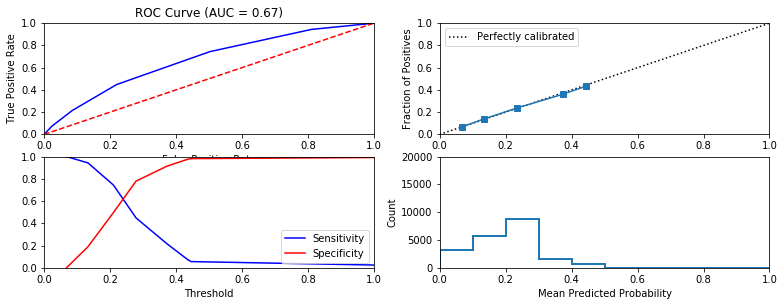


Similarity to LC grade ranking:  0.9987800465795952
Brier score: 0.1493440098234726
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80286667]


In [0]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'grade'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, model_name='L1')

  Model: L2
Fit time: 0.18 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80245
              precision    recall  f1-score   support

  No default     0.8024    1.0000    0.8904     16049
     Default     0.0000    0.0000    0.0000      3951

   micro avg     0.8024    0.8024    0.8024     20000
   macro avg     0.4012    0.5000    0.4452     20000
weighted avg     0.6439    0.8024    0.7145     20000



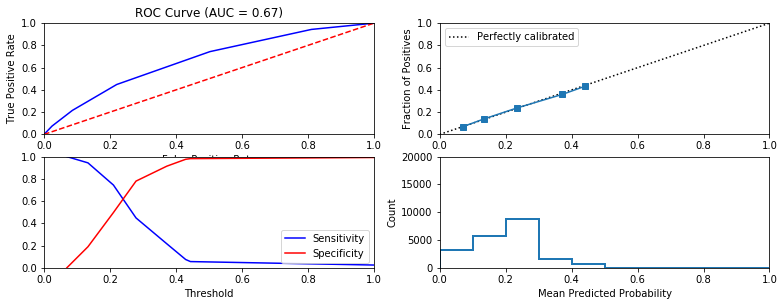


Similarity to LC grade ranking:  0.9987800465795952
Brier score: 0.14934307381601689
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80286667]


In [0]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, model_name='L2')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [0]:
new_features = list(data.columns)
new_features.remove('grade')
new_features.remove('int_rate')
new_features.remove('installment')
new_features

['id',
 'loan_amnt',
 'funded_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'last_pymnt_d',
 'recoveries',
 'loan_length',
 'term_num',
 'ret_PESS',
 'ret_OPT',
 'ret_INTa',
 'ret_INTb',
 'outcome',
 'cr_hist',
 'train']

In [0]:
l1s = []
l2s = []
dts = []
rfs = []
mlps = []
gnb = []

l1_auc = []
l2_auc = []
dt_auc = []
rf_auc = []
mlp_auc = []
gnb_auc = []

no_round = 100
start_time = datetime.datetime.now()
print('start:',start_time)



for idx in range(no_round):
    
    start_time_loop = datetime.datetime.now()
    default_seed = idx
    # Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
    np.random.seed(default_seed)
    ## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
    train_index = np.random.choice(data.index,int(len(data)*0.7))
    data['train'] = data.index.isin(train_index)
    
    # Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
    X_continuous = data[continuous_features].values
    X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
    discrete_features_dummies = X_discrete.columns.tolist()
    X_discrete = X_discrete.values

    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

    y = data.outcome.values

    train = data.train.values
    
    data_dict = prepare_data(feature_subset = new_features)
    
    

    
    cv_parameters = {'C':[0.01,0.1,1]}
    l1_logistic = LogisticRegression(penalty='l1')
    l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, model_name='LogitL1',\
                                    output_to_file = True, print_to_screen = False)
    l1_auc.append(l1_logistic['auc'])

    
    l2_logistic = LogisticRegression(penalty='l2')
    cv_parameters = {'C':[0.01,0.1,1]}
    l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, model_name='LogitL2',\
                                    output_to_file = True, print_to_screen = False)
    l2_auc.append(l2_logistic['auc'])
    
    decision_tree = DecisionTreeClassifier()
    cv_parameters = {'max_depth':[5,10,None],\
                'max_features':['sqrt','log2',None]
                }
    decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, model_name='Decision Tree',\
                                      output_to_file = True, print_to_screen = False)
    dt_auc.append(decision_tree['auc'])
    
    random_forest = RandomForestClassifier()
    cv_parameters = {
                'max_depth':[10,20],\
                 'n_estimators':[20,50,100],\
                }
    random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name='RF',\
                                      output_to_file = True, print_to_screen = False)
    rf_auc.append(random_forest['auc'])
    
    mlp = MLPClassifier()
    cv_parameters = {
                'hidden_layer_sizes':[2,5,10],       
                'activation':['logistic'],
                }
    mlp = fit_classification(mlp, data_dict, cv_parameters, model_name='MLP',\
                            output_to_file = True, print_to_screen = False)
    mlp_auc.append(mlp['auc'])

    
    l1s.append(l1_logistic)
    l2s.append(l2_logistic)
    dts.append(decision_tree)
    rfs.append(random_forest)
    mlps.append(mlp)
    
    
    end_time = datetime.datetime.now()
    print('end round ',idx+1,':',end_time, 'spend: ', end_time - start_time_loop)
end_time = datetime.datetime.now()
print('end:',end_time, 'spend: ', end_time - start_time)


start: 2019-05-02 01:28:38.353396
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  1 : 2019-05-02 01:30:18.859685 spend:  0:01:40.505294
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  2 : 2019-05-02 01:31:40.943556 spend:  0:01:22.082873
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  3 : 2019-05-02 01:32:55.393601 spend:  0:01:14.449046
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  4 : 2019-05-02 01:34:13.130863 spend:  0:01:17.737262
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 95

955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  38 : 2019-05-02 02:18:59.811980 spend:  0:01:10.079723
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  39 : 2019-05-02 02:20:00.378153 spend:  0:01:00.566173
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  40 : 2019-05-02 02:21:05.560935 spend:  0:01:05.181810
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  41 : 2019-05-02 02:22:20.497716 spend:  0:01:14.936781
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533

955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  75 : 2019-05-02 02:55:10.003751 spend:  0:00:59.867826
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  76 : 2019-05-02 02:56:13.997402 spend:  0:01:03.993651
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  77 : 2019-05-02 02:57:09.398572 spend:  0:00:55.401170
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
end round  78 : 2019-05-02 02:58:07.437507 spend:  0:00:58.037939
955533 2010-02-01 955533
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 955533 30000 30000
955533 95553

In [0]:
print('l1:(' + str(round(np.average(l1_auc),4)) + ', +/-' +str(round(np.std(l1_auc),4)) + ')')
print('l2:(' + str(round(np.average(l2_auc),4)) + ', +/-' +str(round(np.std(l2_auc),4)) + ')')
print('DT:(' + str(round(np.average(dt_auc),4)) + ', +/-' +str(round(np.std(dt_auc),4)) + ')')
print('RF:(' + str(round(np.average(rf_auc),4)) + ', +/-' +str(round(np.std(rf_auc),4)) + ')')
print('MLP:(' + str(round(np.average(mlp_auc),4)) + ', +/-' +str(round(np.std(mlp_auc),4)) + ')')

l1:(0.6744, +/-0.011)
l2:(0.6739, +/-0.0076)
DT:(0.6241, +/-0.0151)
RF:(0.6804, +/-0.0066)
MLP:(0.6773, +/-0.0059)


## Time stability test of YOURMODEL

955533 2010-01-01 955533
  Model: RF
Fit time: 66.26 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.38158704897469287
Accuracy:  0.79665
              precision    recall  f1-score   support

  No default     0.8192    0.9579    0.8832     16049
     Default     0.4530    0.1415    0.2156      3951

   micro avg     0.7966    0.7966    0.7966     20000
   macro avg     0.6361    0.5497    0.5494     20000
weighted avg     0.7469    0.7966    0.7513     20000



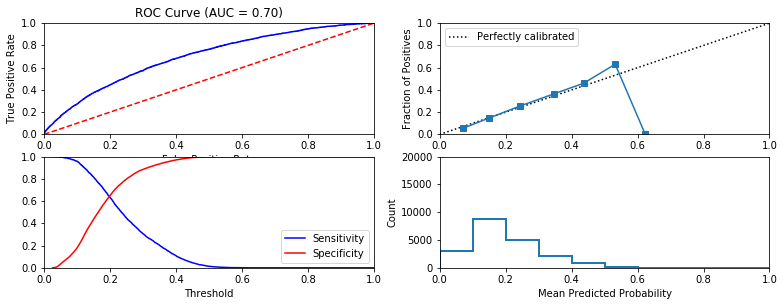

955533 955533 30000 955533

Similarity to LC grade ranking:  0.7230550918702877
Brier score: 0.14619835047494467


In [0]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
random_forest = RandomForestClassifier()
cv_parameters = {
            'max_depth':[10,20],\
             'n_estimators':[20,50,100],\
            }
random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name='RF',\
                                      output_to_file = False, print_to_screen = True)

955533 2016-01-01 955533
  Model: RF
Fit time: 64.97 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.38158704897469287
Accuracy:  0.79665
              precision    recall  f1-score   support

  No default     0.8192    0.9579    0.8832     16049
     Default     0.4530    0.1415    0.2156      3951

   micro avg     0.7966    0.7966    0.7966     20000
   macro avg     0.6361    0.5497    0.5494     20000
weighted avg     0.7469    0.7966    0.7513     20000



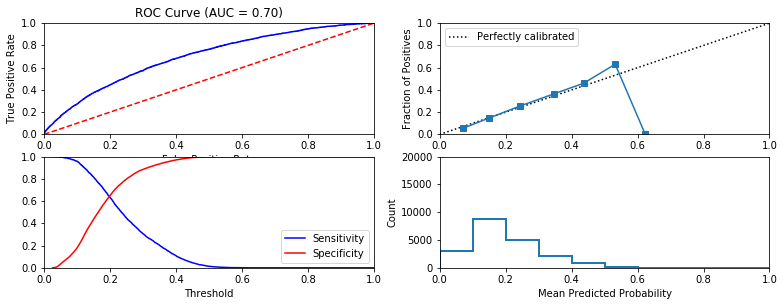

955533 955533 30000 955533

Similarity to LC grade ranking:  0.7230550918702877
Brier score: 0.14619835047494467


In [0]:
## Define the time window of your train and test data
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
random_forest = RandomForestClassifier()
cv_parameters = {
            'max_depth':[10,20],\
             'n_estimators':[20,50,100],\
            }
random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name='RF',\
                                      output_to_file = False, print_to_screen = True)

## Train and test YOURMODEL on the original data

In [0]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [0]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

In [0]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += '/'
    
    all_files = [] # get list of all files from the directory
    for r, d, f in os.walk(directory):
        for file in f:
            all_files.append(r + file)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i]  = pd.read_csv(i, delimiter=',', header=1,dtype = 'str') # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].map(lambda x: is_integer(x) == False) # mask rows that have non-integer IDs. Use is_integer method
        
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][ invalid_rows == False] # remove invalid rows
    
    return output # return dictionary of dataframe

In [0]:
# Define the directories that contain the files downloaded
dir_cs = './1805_download/' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = './output/' + "clean_data.pickle" # path to save cleaned data

In [0]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory ./1805_download/ has 12 files:
    Reading file ./1805_download/LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file ./1805_download/LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file ./1805_download/LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file

In [0]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 
                'installment', 'grade', 'sub_grade',  'emp_length',
                'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
                'purpose', 'addr_state', 'dti','total_pymnt', 'delinq_2yrs', 'earliest_cr_line', 
                'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high', 'fico_range_low',
                'last_fico_range_low', 'last_fico_range_high', 'application_type',
                'revol_bal', 'revol_util', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',  'annual_inc','dti','delinq_2yrs',
              'open_acc', 'total_pymnt', 'pub_rec', 'last_pymnt_amnt', 'fico_range_high', 'fico_range_low',
              'last_fico_range_low', 'last_fico_range_high', 'revol_bal','recoveries' ]
cat_cols = [ 'term', 'grade','sub_grade', 'emp_length','home_ownership', 'verification_status', 
            'loan_status','purpose', 'addr_state','application_type' ] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [0]:
# discrete features
discrete_features = list(set(cat_cols) - set(["loan_status"]))
# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

In [0]:
data_cs = pd.DataFrame(pd.concat(files_cs)) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick].reset_index().drop(columns = ['level_0','level_1'])
final_data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_low,last_fico_range_high,application_type,revol_bal,revol_util,recoveries
0,1077501,5000,5000,4975,36 months,10.65%,162.87,B,B2,10+ years,...,Jan-2015,171.62,739,735,715,719,Individual,13648,83.7%,0.0
1,1077430,2500,2500,2500,60 months,15.27%,59.83,C,C4,< 1 year,...,Apr-2013,119.66,744,740,0,499,Individual,1687,9.4%,122.9
2,1077175,2400,2400,2400,36 months,15.96%,84.33,C,C5,10+ years,...,Jun-2014,649.91,739,735,735,739,Individual,2956,98.5%,0.0
3,1076863,10000,10000,10000,36 months,13.49%,339.31,C,C1,10+ years,...,Jan-2015,357.48,694,690,600,604,Individual,5598,21%,0.0
4,1075358,3000,3000,3000,60 months,12.69%,67.79,B,B5,1 year,...,Jan-2017,67.3,699,695,680,684,Individual,27783,53.9%,0.0


In [0]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


In [0]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1
for i in float_cols:
    final_data[i] =   final_data[i].astype(float) # typecast float columns

In [0]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].map(lambda x : clean_perc(x)) # apply clean_perc to percentage columns


In [0]:
def clean_date(x):
    if pd.isnull(x) or x=='None':
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].map(lambda x : clean_date(x)) # typecast date cloumns to datatime using clean_date

In [0]:
for i in cat_cols:
    final_data[i] = np.where(final_data[i].isnull(), None, final_data[i])
    final_data[i] = np.where(final_data[i]=='None', None, final_data[i])

In [0]:
final_data

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_low,last_fico_range_high,application_type,revol_bal,revol_util,recoveries
0,1077501,5000.0,5000.0,4975.000000,36 months,10.65,162.87,B,B2,10+ years,...,2015-01-01,171.62,739.0,735.0,715.0,719.0,Individual,13648.0,83.70,0.00
1,1077430,2500.0,2500.0,2500.000000,60 months,15.27,59.83,C,C4,< 1 year,...,2013-04-01,119.66,744.0,740.0,0.0,499.0,Individual,1687.0,9.40,122.90
2,1077175,2400.0,2400.0,2400.000000,36 months,15.96,84.33,C,C5,10+ years,...,2014-06-01,649.91,739.0,735.0,735.0,739.0,Individual,2956.0,98.50,0.00
3,1076863,10000.0,10000.0,10000.000000,36 months,13.49,339.31,C,C1,10+ years,...,2015-01-01,357.48,694.0,690.0,600.0,604.0,Individual,5598.0,21.00,0.00
4,1075358,3000.0,3000.0,3000.000000,60 months,12.69,67.79,B,B5,1 year,...,2017-01-01,67.30,699.0,695.0,680.0,684.0,Individual,27783.0,53.90,0.00
5,1075269,5000.0,5000.0,5000.000000,36 months,7.90,156.46,A,A4,3 years,...,2015-01-01,161.03,734.0,730.0,560.0,564.0,Individual,7963.0,28.30,0.00
6,1069639,7000.0,7000.0,7000.000000,60 months,15.96,170.08,C,C5,8 years,...,2016-05-01,1313.76,694.0,690.0,650.0,654.0,Individual,17726.0,85.60,0.00
7,1072053,3000.0,3000.0,3000.000000,36 months,18.64,109.43,E,E1,9 years,...,2015-01-01,111.34,664.0,660.0,685.0,689.0,Individual,8221.0,87.50,0.00
8,1071795,5600.0,5600.0,5600.000000,60 months,21.28,152.39,F,F2,4 years,...,2012-04-01,152.39,679.0,675.0,0.0,499.0,Individual,5210.0,32.60,190.54
9,1071570,5375.0,5375.0,5350.000000,60 months,12.69,121.45,B,B5,< 1 year,...,2012-11-01,121.45,729.0,725.0,500.0,504.0,Individual,9279.0,36.50,277.69


In [0]:
data = final_data.copy()

In [0]:
len(data)

1765426

In [0]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")
n_rows = len(data)
data.dropna(subset=required_cols, inplace=True) # drop rows that contain null based only on "required_cols"
print("Removed " + str(n_rows - len(data)) + " rows")

Removed 3564 rows


In [0]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].isin(['Charged Off', 'Default'])
data["outcome"].head()

0    False
1     True
2    False
3    False
4    False
Name: outcome, dtype: bool

In [0]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [0]:
default_seed = 1
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
train_index = np.random.choice(data.index,int(len(data)*0.7))
data['train'] = data.index.isin(train_index)
data['train'].head()

0    False
1     True
2    False
3    False
4     True
Name: train, dtype: bool

In [0]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [0]:
# prepare the train, test data for training models
data_dict = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = cols_to_pick)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in cols_to_pick]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)


1761862 2010-02-01 1761862


  Model: RF
Fit time: 33.87 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.43782706481963557
Accuracy:  0.97205
              precision    recall  f1-score   support

  No default     0.9783    0.9905    0.9844     17758
     Default     0.9164    0.8260    0.8689      2242

   micro avg     0.9720    0.9720    0.9720     20000
   macro avg     0.9473    0.9083    0.9266     20000
weighted avg     0.9714    0.9720    0.9714     20000



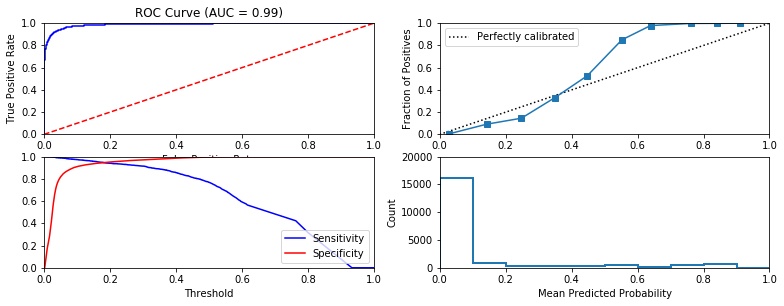

1761862 1761862 30000 1761862

Similarity to LC grade ranking:  0.3574505522885094
Brier score: 0.02714989398739614


In [0]:
random_forest = RandomForestClassifier()
# cv_parameters = {'n_estimators': [10,20],
#                  'max_features': ['sqrt','log2'],
#                  'max_depth': range(1,20,5)}
cv_parameters = {
            'max_depth':[10,20],\
             'n_estimators':[20,50,100],\
            }
random_forest = fit_classification(random_forest, data_dict, cv_parameters, model_name='RF',\
                                      output_to_file = False, print_to_screen = True)

In [0]:
random_forest

{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([ True, False, False, ..., False, False, False]),
 'auc': 0.9881124301856288,
 'y_pred_probs': array([0.51538266, 0.01343047, 0.01094321, ..., 0.00709918, 0.0242435 ,
        0.084509  ])}

## Test regression models

In [0]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    global data
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [0]:
default_seed = 1
output_file = "output_sample"

# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")
        
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "output\clean_data.pickle", "rb" ) )

## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].isin(['Charged Off', 'Default'])
data["outcome"].head()

# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
train_index = np.random.choice(data.index,int(len(data)*0.7))
data['train'] = data.index.isin(train_index)
data['train'].head()

# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [0]:
data_dict = prepare_data(feature_subset = new_features)

955533 2010-02-01 955533


### $l_1$ regularized linear regression

In [0]:
len(train)

955533

In [0]:
## First, trying l1 regularized linear regression with hyper-parameters
from sklearn.linear_model import Lasso
cv_parameters = {'alpha':[1e-09,1e-07,1e-05,1e-03],
                'max_iter':[10,20]
                }

reg_lasso = fit_regression(Lasso(),data_dict, cv_parameters,model_name='Lasso')

  Model: Lasso  Return column: ret_PESS
Fit time: 1.28 seconds
Optimal parameters:
{'alpha': 1e-07, 'max_iter': 20}

Testing r2 score: 0.03006423698945726
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -13.885983146995635
All test scores : [-0.13337411 -0.1332398  -0.13336994 -0.13323618 -0.13331087 -0.13326419
 -0.15173711 -0.15173733]
  Model: Lasso  Return column: ret_OPT
Fit time: 1.39 seconds
Optimal parameters:
{'alpha': 1e-05, 'max_iter': 20}

Testing r2 score: 0.01463683635244395
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -9.905402741465961
All test scores : [-0.02613292 -0.02608593 -0.02612774 -0.02608096 -0.02566235 -0.02563981
 -0.02817788 -0.02817954]
  Model: Lasso  Return column: ret_INTa
Fit time: 1.61 seconds
Optimal parameters:
{'alpha': 1e-07, 'max_iter': 20}

Testing r2 score: 0.034243153069654086
Were parameters on edge (model) : True
Score variations around CV search grid (model) 

### $l_2$ regularized linear regressor

In [0]:
## trying l2 regularized linear regression with hyper-parameters
from sklearn.linear_model import Ridge
cv_parameters = {'alpha':[10,100,1000],
                'max_iter':[10,20]}
reg_ridge = fit_regression(Ridge(),data_dict, cv_parameters,model_name='Ridge')

  Model: Ridge  Return column: ret_PESS
Fit time: 1.19 seconds
Optimal parameters:
{'alpha': 10, 'max_iter': 10}

Testing r2 score: 0.02950542407943524
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -7.525770854640701
All test scores : [-0.13727189 -0.13727189 -0.14494071 -0.14494071 -0.14760265 -0.14760265]
  Model: Ridge  Return column: ret_OPT
Fit time: 0.86 seconds
Optimal parameters:
{'alpha': 10, 'max_iter': 10}

Testing r2 score: 0.014338344671791514
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -14.108257306706545
All test scores : [-0.02765946 -0.02765946 -0.03156172 -0.03156172 -0.03036518 -0.03036518]
  Model: Ridge  Return column: ret_INTa
Fit time: 1.29 seconds
Optimal parameters:
{'alpha': 10, 'max_iter': 10}

Testing r2 score: 0.03377604857834615
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -7.165018147478496
All test scores : [-0.12425324 -0.1242

### Multi-layer perceptron regressor

In [0]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'hidden_layer_sizes':[20,40],\
                 'alpha':[1e-03,0.1],
                'activation':['identity','logistic'],\
                 'learning_rate_init':[0.1],
                 'early_stopping':[True]
                }

reg_mlp = fit_regression(MLPRegressor(),data_dict,cv_parameters,model_name='reg_mlp')

  Model: reg_mlp  Return column: ret_PESS
Fit time: 127.85 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.1}

Testing r2 score: 0.010858321527137504
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -123.32179563813266
All test scores : [-0.13312446 -0.17136939 -0.15214999 -0.17836959 -0.15907819 -0.13811966
 -0.19339682 -0.1669637  -0.17297675 -0.2487766  -0.14881582 -0.28105861
 -0.16400495 -0.14948887 -0.16836747 -0.14585117 -0.15808961 -0.17778098
 -0.12585364 -0.1795393  -0.1909827  -0.20475606 -0.1382769  -0.18376627]
  Model: reg_mlp  Return column: ret_OPT
Fit time: 116.15 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': 20, 'learning_rate_init': 0.1}

Testing r2 score: 0.008466634873701917
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -247

### Random forest regressor

In [0]:
## trying random forest regression with hyper-parameters

cv_parameters = {
            'max_depth':[3,5,7],\
             'n_estimators':[20],\
            }

reg_rf = fit_regression(RandomForestRegressor(),data_dict,cv_parameters,model_name='reg_rf')

  Model: reg_rf  Return column: ret_PESS
Fit time: 29.28 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 20}

Testing r2 score: 0.03791782149781919
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -12.861175812836978
All test scores : [-0.17313419 -0.16009005 -0.15340456]
  Model: reg_rf  Return column: ret_OPT
Fit time: 27.63 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 20}

Testing r2 score: 0.022244965524187643
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -14.812722665842017
All test scores : [-0.0258844  -0.02445849 -0.02808146]
  Model: reg_rf  Return column: ret_INTa
Fit time: 30.5 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 20}

Testing r2 score: 0.04271339702758503
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -8.676632641475795
All test scores : [-0.14119653 -0.13290608 -0.12992354]
  Model: reg_rf  Return col

In [0]:
l1s_r = []
l2s_r  = []
rfs_r  = []
mlps_r  = []

no_round = 100
start_time = datetime.datetime.now()
print('start:',start_time)

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

for idx in range(no_round):
    
    l1_r  = []
    l2_r  = []
    rf_r  = []
    mlp_r  = []
    
    start_time_loop = datetime.datetime.now()
    default_seed = idx
    # Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the same training/test split
    np.random.seed(default_seed)
    ## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
    train_index = np.random.choice(data.index,int(len(data)*0.7))
    data['train'] = data.index.isin(train_index)
    
    # Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
    X_continuous = data[continuous_features].values
    X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
    discrete_features_dummies = X_discrete.columns.tolist()
    X_discrete = X_discrete.values

    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

    y = data.outcome.values

    train = data.train.values
    
    data_dict = prepare_data(feature_subset = new_features)
    
    
    cv_parameters = {'alpha':[1e-09,1e-07,1e-05,1e-03],
                    'max_iter':[10,20]
                    }
    reg_lasso = fit_regression(Lasso(),data_dict, cv_parameters,model_name='Lasso',print_to_screen=False)
        
    
    cv_parameters = {'alpha':[10,100,1000],
                    'max_iter':[10,20]}
    reg_ridge = fit_regression(Ridge(),data_dict, cv_parameters,model_name='Ridge',print_to_screen=False)
        
    
    
    cv_parameters = {'hidden_layer_sizes':[20,40],\
                     'alpha':[1e-03,0.1],
                    'activation':['identity','logistic'],\
                     'learning_rate_init':[0.1],
                     'early_stopping':[True]
                    }
    reg_mlp = fit_regression(MLPRegressor(),data_dict,cv_parameters,model_name='reg_mlp',print_to_screen=False)
    
        
    
    cv_parameters = {
            'max_depth':[3,5,7],\
             'n_estimators':[20],\
            }
    reg_rf = fit_regression(RandomForestRegressor(),data_dict,cv_parameters,model_name='reg_rf',print_to_screen=False)

    for a in col_list:
        l1_r.append(reg_lasso[a]['r2_scores'])
        l2_r.append(reg_ridge[a]['r2_scores'])
        rf_r.append(reg_rf[a]['r2_scores'])
        mlp_r.append(reg_mlp[a]['r2_scores'])

    
    l1s_r.append(l1_r)
    l2s_r.append(l2_r)
    rfs_r.append(rf_r)
    mlps_r.append(mlp_r)
    
    
    end_time = datetime.datetime.now()
    print('end round ',idx+1,':',end_time, 'spend: ', end_time - start_time_loop)
end_time = datetime.datetime.now()
print('end:',end_time, 'spend: ', end_time - start_time)

start: 2019-05-03 01:40:38.003655
955533 2010-02-01 955533
end round  1 : 2019-05-03 01:44:26.092518 spend:  0:03:48.087829
955533 2010-02-01 955533
end round  2 : 2019-05-03 01:47:20.875192 spend:  0:02:54.782674
955533 2010-02-01 955533
end round  3 : 2019-05-03 01:50:18.904439 spend:  0:02:58.028221
955533 2010-02-01 955533
end round  4 : 2019-05-03 01:53:03.495643 spend:  0:02:44.591204
955533 2010-02-01 955533
end round  5 : 2019-05-03 01:55:50.839396 spend:  0:02:47.343753
955533 2010-02-01 955533
end round  6 : 2019-05-03 01:59:21.700376 spend:  0:03:30.860980
955533 2010-02-01 955533
end round  7 : 2019-05-03 02:03:14.065283 spend:  0:03:52.363910
955533 2010-02-01 955533
end round  8 : 2019-05-03 02:06:50.317670 spend:  0:03:36.252387
955533 2010-02-01 955533
end round  9 : 2019-05-03 02:10:58.329822 spend:  0:04:08.012152
955533 2010-02-01 955533
end round  10 : 2019-05-03 02:14:51.907866 spend:  0:03:53.578044
955533 2010-02-01 955533
end round  11 : 2019-05-03 02:18:49.4572

955533 2010-02-01 955533
end round  91 : 2019-05-03 05:44:17.730853 spend:  0:02:30.931701
955533 2010-02-01 955533
end round  92 : 2019-05-03 05:46:47.965812 spend:  0:02:30.234959
955533 2010-02-01 955533
end round  93 : 2019-05-03 05:49:25.526348 spend:  0:02:37.560536
955533 2010-02-01 955533
end round  94 : 2019-05-03 05:51:55.115265 spend:  0:02:29.588917
955533 2010-02-01 955533
end round  95 : 2019-05-03 05:54:35.675629 spend:  0:02:40.560364
955533 2010-02-01 955533
end round  96 : 2019-05-03 05:57:09.278584 spend:  0:02:33.602955
955533 2010-02-01 955533
end round  97 : 2019-05-03 05:59:47.357996 spend:  0:02:38.079412
955533 2010-02-01 955533
end round  98 : 2019-05-03 06:02:19.887827 spend:  0:02:32.529831
955533 2010-02-01 955533
end round  99 : 2019-05-03 06:04:54.857870 spend:  0:02:34.970043
955533 2010-02-01 955533
end round  100 : 2019-05-03 06:07:26.001981 spend:  0:02:31.144111
end: 2019-05-03 06:07:26.002944 spend:  4:26:47.999289


In [0]:
print('l1:(' + str(np.around(np.average(l1s_r, axis=0),4)) + ', +/-' +str(np.around(np.std(l1s_r, axis=0),4)) + ')')
print('l2:(' + str(np.around(np.average(l2s_r, axis=0),4)) + ', +/-' +str(np.around(np.std(l2s_r, axis=0),4)) + ')')
print('RF:(' + str(np.around(np.average(rfs_r, axis=0),4)) + ', +/-' +str(np.around(np.std(rfs_r, axis=0),4)) + ')')
print('MLP:(' + str(np.around(np.average(mlps_r, axis=0),4)) + ', +/-' +str(np.around(np.std(mlps_r, axis=0),4)) + ')')

l1:([0.0289 0.0122 0.0324 0.0326], +/-[0.0035 0.0039 0.0038 0.0037])
l2:([0.0276 0.0118 0.0311 0.0311], +/-[0.003  0.0028 0.0032 0.0034])
RF:([0.0288 0.0149 0.0346 0.034 ], +/-[0.0025 0.0022 0.0033 0.0032])
MLP:([0.0176 0.006  0.0199 0.0214], +/-[0.0057 0.0029 0.0065 0.0058])


## Test investment strategies 
Now we test several investment strategies using the learning models above

In [0]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [0]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict,regressor=reg_rf, classifier=random_forest,strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.006526728674207432
ret_OPT: 0.04301908048441405
ret_INTa: 0.016078799840601968
ret_INTb: 0.055949484334876176


In [0]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict,regressor=reg_rf, classifier=random_forest,strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.016618991970803316
ret_OPT: 0.04778671676541112
ret_INTa: 0.022902065841429908
ret_INTb: 0.05901051541551429


In [0]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict,regressor=reg_rf, classifier=random_forest,strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.03816948405593669
ret_OPT: 0.04464982907508707
ret_INTa: 0.01975014542049372
ret_INTb: 0.055927681415713665


In [0]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {
            'max_depth':[3,5,7],\
             'n_estimators':[20],\
            }

reg_separate = fit_regression(RandomForestRegressor(),data_dict,cv_parameters,model_name='reg_rf', separate = True,\
                             output_to_file = False, print_to_screen = False)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict,regressor=reg_separate, classifier=random_forest,strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.032242466691266236
ret_OPT: 0.050077624432550726
ret_INTa: 0.024653317673172626
ret_INTb: 0.060202706945103844


In [0]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
print('strategy: Best')

for ret_col in col_list:
    print(ret_col + ': ' + str(np.average(-np.sort(np.array(-data[ret_col]))[:1000])))

strategy: Best
ret_PESS: 0.14362329754166342
ret_OPT: 0.404700973461323
ret_INTa: 0.16286494811266136
ret_INTb: 0.20356227966050486


In [0]:
best_classifier = random_forest
best_regressor = reg_rf

In [0]:
strat_rand_all = {}
strat_def_all = {}
strat_ret_all = {}
strat_defret_all = {}
strat_all = [strat_rand_all, strat_def_all, strat_ret_all, strat_defret_all] 
for temp in strat_all:
    temp['ret_PESS'] = []
    temp['ret_OPT'] = []
    temp['ret_INTa'] = []
    temp['ret_INTb'] = []

for i in range(100):
    strat_rand = test_investments(data_dict, classifier = best_classifier, regressor = best_regressor,
                                 strategy = 'Random', random_state = i)
    strat_def = test_investments(data_dict, classifier = best_classifier, regressor = best_regressor,
                                 strategy = 'Default-based', random_state = i)
    strat_ret = test_investments(data_dict, classifier = best_classifier, regressor = best_regressor,
                                 strategy = 'Return-based', random_state = i)
    strat_defret = test_investments(data_dict, classifier = best_classifier, regressor = reg_separate,
                                 strategy = 'Default-return-based', random_state = i)
    for ret_col in col_list:
        strat_rand_all[ret_col].append(strat_rand[ret_col]['average return'])
        strat_def_all[ret_col].append(strat_def[ret_col]['average return'])
        strat_ret_all[ret_col].append(strat_ret[ret_col]['average return'])
        strat_defret_all[ret_col].append(strat_defret[ret_col]['average return'])

In [0]:
strategy_list = ['Rand', 'Def', 'Ret', 'DefRet', 'Best']
count = 0
all_line = []
for temp in strat_all:
    line = []
    line.append(np.mean(temp['ret_PESS']))
    line.append(np.mean(temp['ret_OPT']))
    line.append(np.mean(temp['ret_INTa']))
    line.append(np.mean(temp['ret_INTb']))
    all_line.append(line) 
    count+=1

In [0]:
all_line

array([[0.34927455, 4.5940641 , 2.20798184, 5.69512403],
       [1.6618992 , 4.77867168, 2.29020658, 5.90105154],
       [3.81694841, 4.46498291, 1.97501454, 5.59276814],
       [3.22424667, 5.00776244, 2.46533177, 6.02027069]])

In [0]:
pd.DataFrame(all_line*np.array([100]), columns = ['M1','M2', 'M3(1.2%)', 'M3(3%)'], index = strategy_list[:-1])

,M1,M2,M3(1.2%),M3(3%)
Rand,0.349275,4.594064,2.207982,5.695124
Def,1.661899,4.778672,2.290207,5.901052
Ret,3.816948,4.464983,1.975015,5.592768
DefRet,3.224247,5.007762,2.465332,6.020271


## Sensitivity test of portfolio size

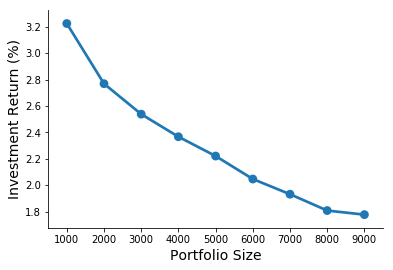

In [0]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    result = []
    for i in range(100):
        reg_0 = test_investments(data_dict, classifier = best_classifier, regressor = reg_separate,
                                 strategy = 'Default-return-based', random_state = i, num_loans = num_loans)
        result.append(reg_0['ret_PESS']['average return'])
    result_sensitivity.append(np.average(result))
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()